In [1]:
import scanpy as sc
import STCOGAT
import warnings
from STCOGAT.Utils import *
from STCOGAT.data_preprocess import *

warnings.filterwarnings('ignore')
sc.set_figure_params(dpi=300,fontsize=10,dpi_save=300,facecolor='white',format='pdf')
sc.settings.figdir = './Result/Lymph_Node/'
outdir = './Result/Lymph_Node/'

cuda:0


## Preprocessing

In [86]:
data_root = './data/Human_Lymph_Node/'
adata = sc.read_visium(data_root)
adata.var_names_make_unique()
GC = pd.read_excel(data_root+'manual_GC_annot.xlsx', index_col=0)
adata.obs['cell_type'] = GC['cell_type']

sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata,min_genes=3)
adata

AnnData object with n_obs × n_vars = 4035 × 22411
    obs: 'in_tissue', 'array_row', 'array_col', 'cell_type', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [87]:
STCOGAT.main.INTER_DIM = 450  
STCOGAT.main.EMBEDDING_DIM = 40  
STCOGAT.main.NUM_LAYERS = 3
STCOGAT.main.DE_GENES_NUM = 2000
STCOGAT.main.pre_emb_dim = 14
STCOGAT.main.lambda_cluster = 0.1
STCOGAT.main.lambda_smooth = 0.1
STCOGAT.main.lambda_contra = 0.1
STCOGAT.main.use_rows_encoder = True
STCOGAT.main.num_clusters = 10

In [88]:
ad, raw = svg(adata, svg_method='gft_top', n_top=3000)

In [ ]:
adata = ad.copy()
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=15)  
net, genet, node_feature = STCOGAT.build_coexpres_network(adata, cut=0.15, method='pearson',percentile=0)
print('genet:',genet,'node_feature:',node_feature.shape)
knn_edge_index = STCOGAT.build_fused_graph(adata,alpha=0.5,k_spat=8,knn_method='KNN',rad_cutoff=150, prune=True)
print('Initial knn_edge_index:', knn_edge_index.shape)
STCOGAT.run_STCOGAT(adata, genet,node_feature,knn_edge_index, number_of_batches=3,max_epoch=300, model_name ="Lymph_Node_cluster",save_model_flag=True)


genet: Graph with 2975 nodes and 355813 edges node_feature: (2975, 4035)
Initial knn_edge_index: torch.Size([2, 50972])


Training: 100%|██████████| 300/300 [20:21<00:00,  4.07s/it, recon=2.9627, clust=0.0001]


STCOGAT(
  (encoder): MutualEncoder(
    (rows_layers): ModuleList(
      (0-2): 3 x Sequential(
        (0) - SAGEConv(4035, 4035, aggr=mean): x, edge_index -> x1
        (1) - Dropout(p=0.2, inplace=False): x1 -> x2
        (2) - LeakyReLU(negative_slope=0.01, inplace=True): x2 -> x2
      )
    )
    (cols_layers): ModuleList(
      (0-2): 3 x Sequential(
        (0) - SAGEConv(2975, 2975, aggr=mean): x, edge_index -> x1
        (1) - LeakyReLU(negative_slope=0.01, inplace=True): x1 -> x1
        (2) - Dropout(p=0.2, inplace=False): x1 -> x2
      )
    )
  )
  (rows_encoder): DimEncoder(
    (gcn): GATConv(4035, 450, heads=1)
    (res_proj1): Linear(in_features=4035, out_features=450, bias=False)
    (norm1): BatchNorm1d(450, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (trans): GATConv(450, 28, heads=1)
    (res_proj2): Linear(in_features=450, out_features=28, bias=False)
    (norm2): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

## Clustering the gene embedding and the original counts.

In [127]:
embedded_genes, embedded_cells, node_features , out_features = STCOGAT.load_embeddings("Lymph_Node_gene")
embedded_genes.shape,embedded_cells.shape,node_features.shape,out_features.shape

((2975, 28), (4035, 42), (2975, 4035), (4035, 2975))

In [128]:
node_features = raw.to_df()[node_features.index].T

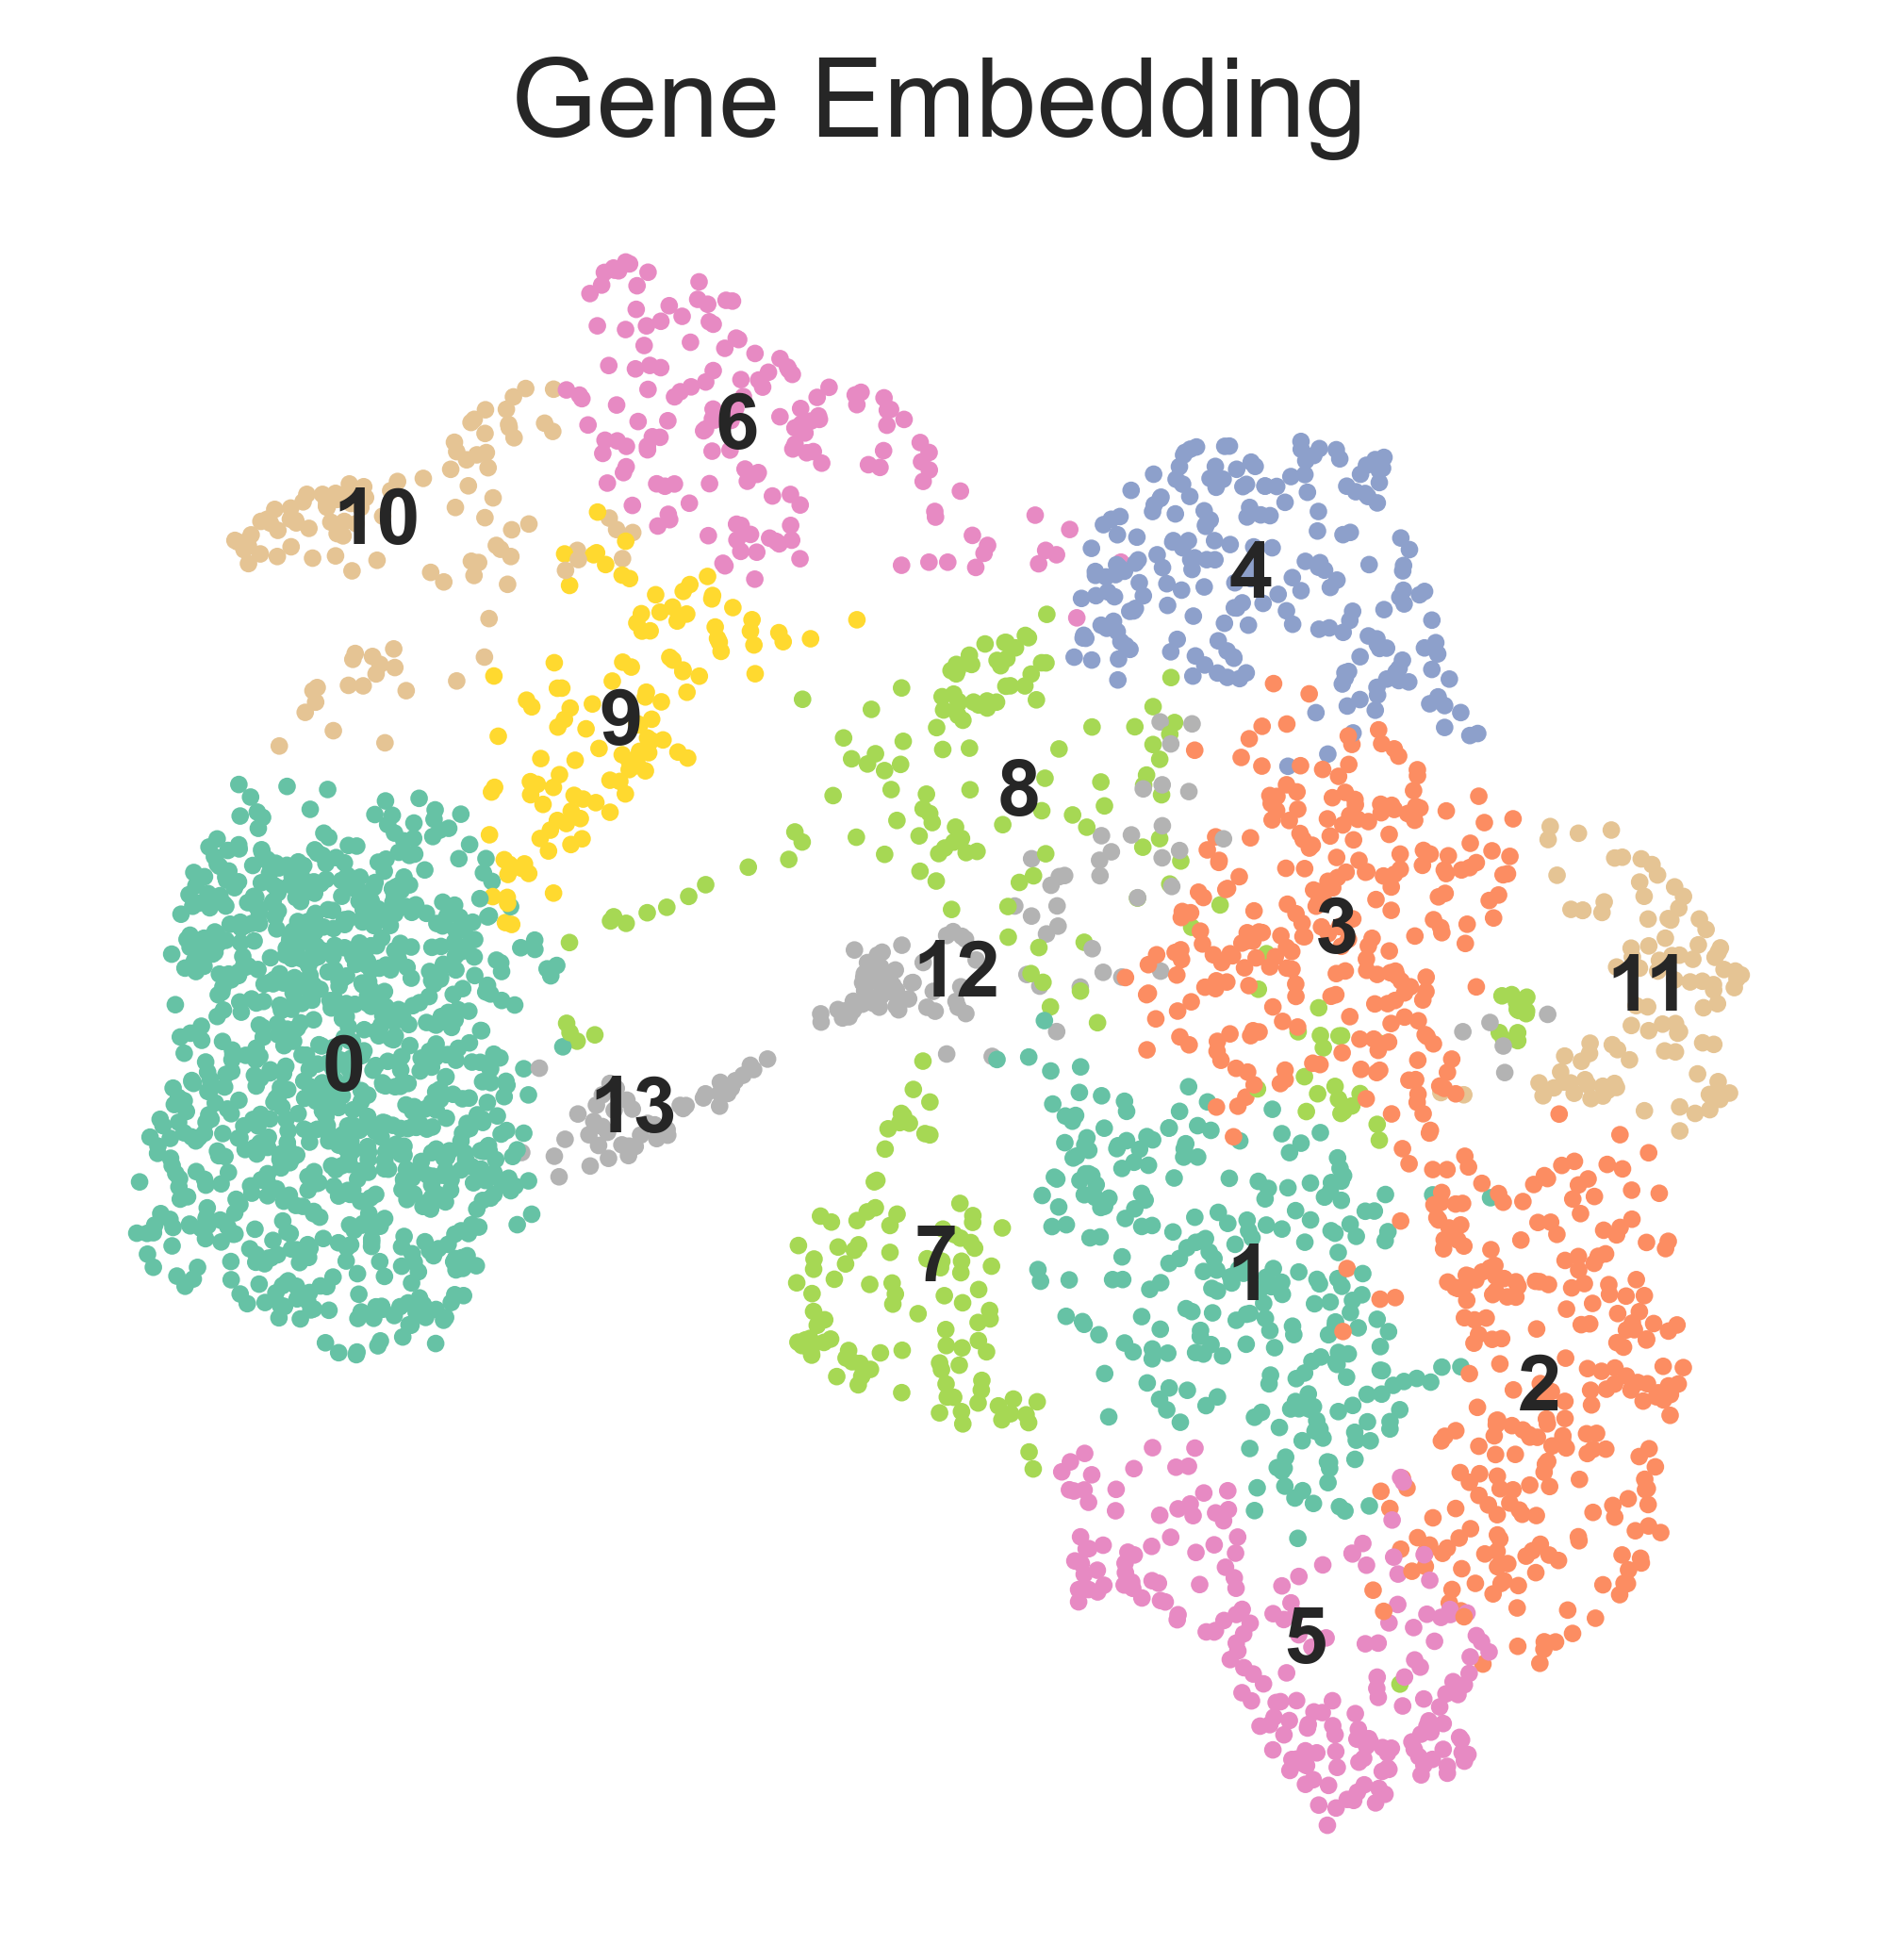

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

gene_names = node_features.index  
adata_embed = sc.AnnData(X=embedded_genes)
adata_embed.obs_names = gene_names
adata_embed.var_names = [f"dim_{i}" for i in range(embedded_genes.shape[1])]

sc.pp.neighbors(adata_embed, n_neighbors=10, use_rep="X")  
sc.tl.leiden(adata_embed, resolution=0.7)                    
sc.tl.umap(adata_embed)                                   
plt.rcParams.update({'axes.titlesize': 14})
sc.pl.umap(adata_embed, color="leiden", legend_loc="on data", legend_fontsize=10,
           title="Gene Embedding", frameon=False, 
           palette="Set2", size=20)


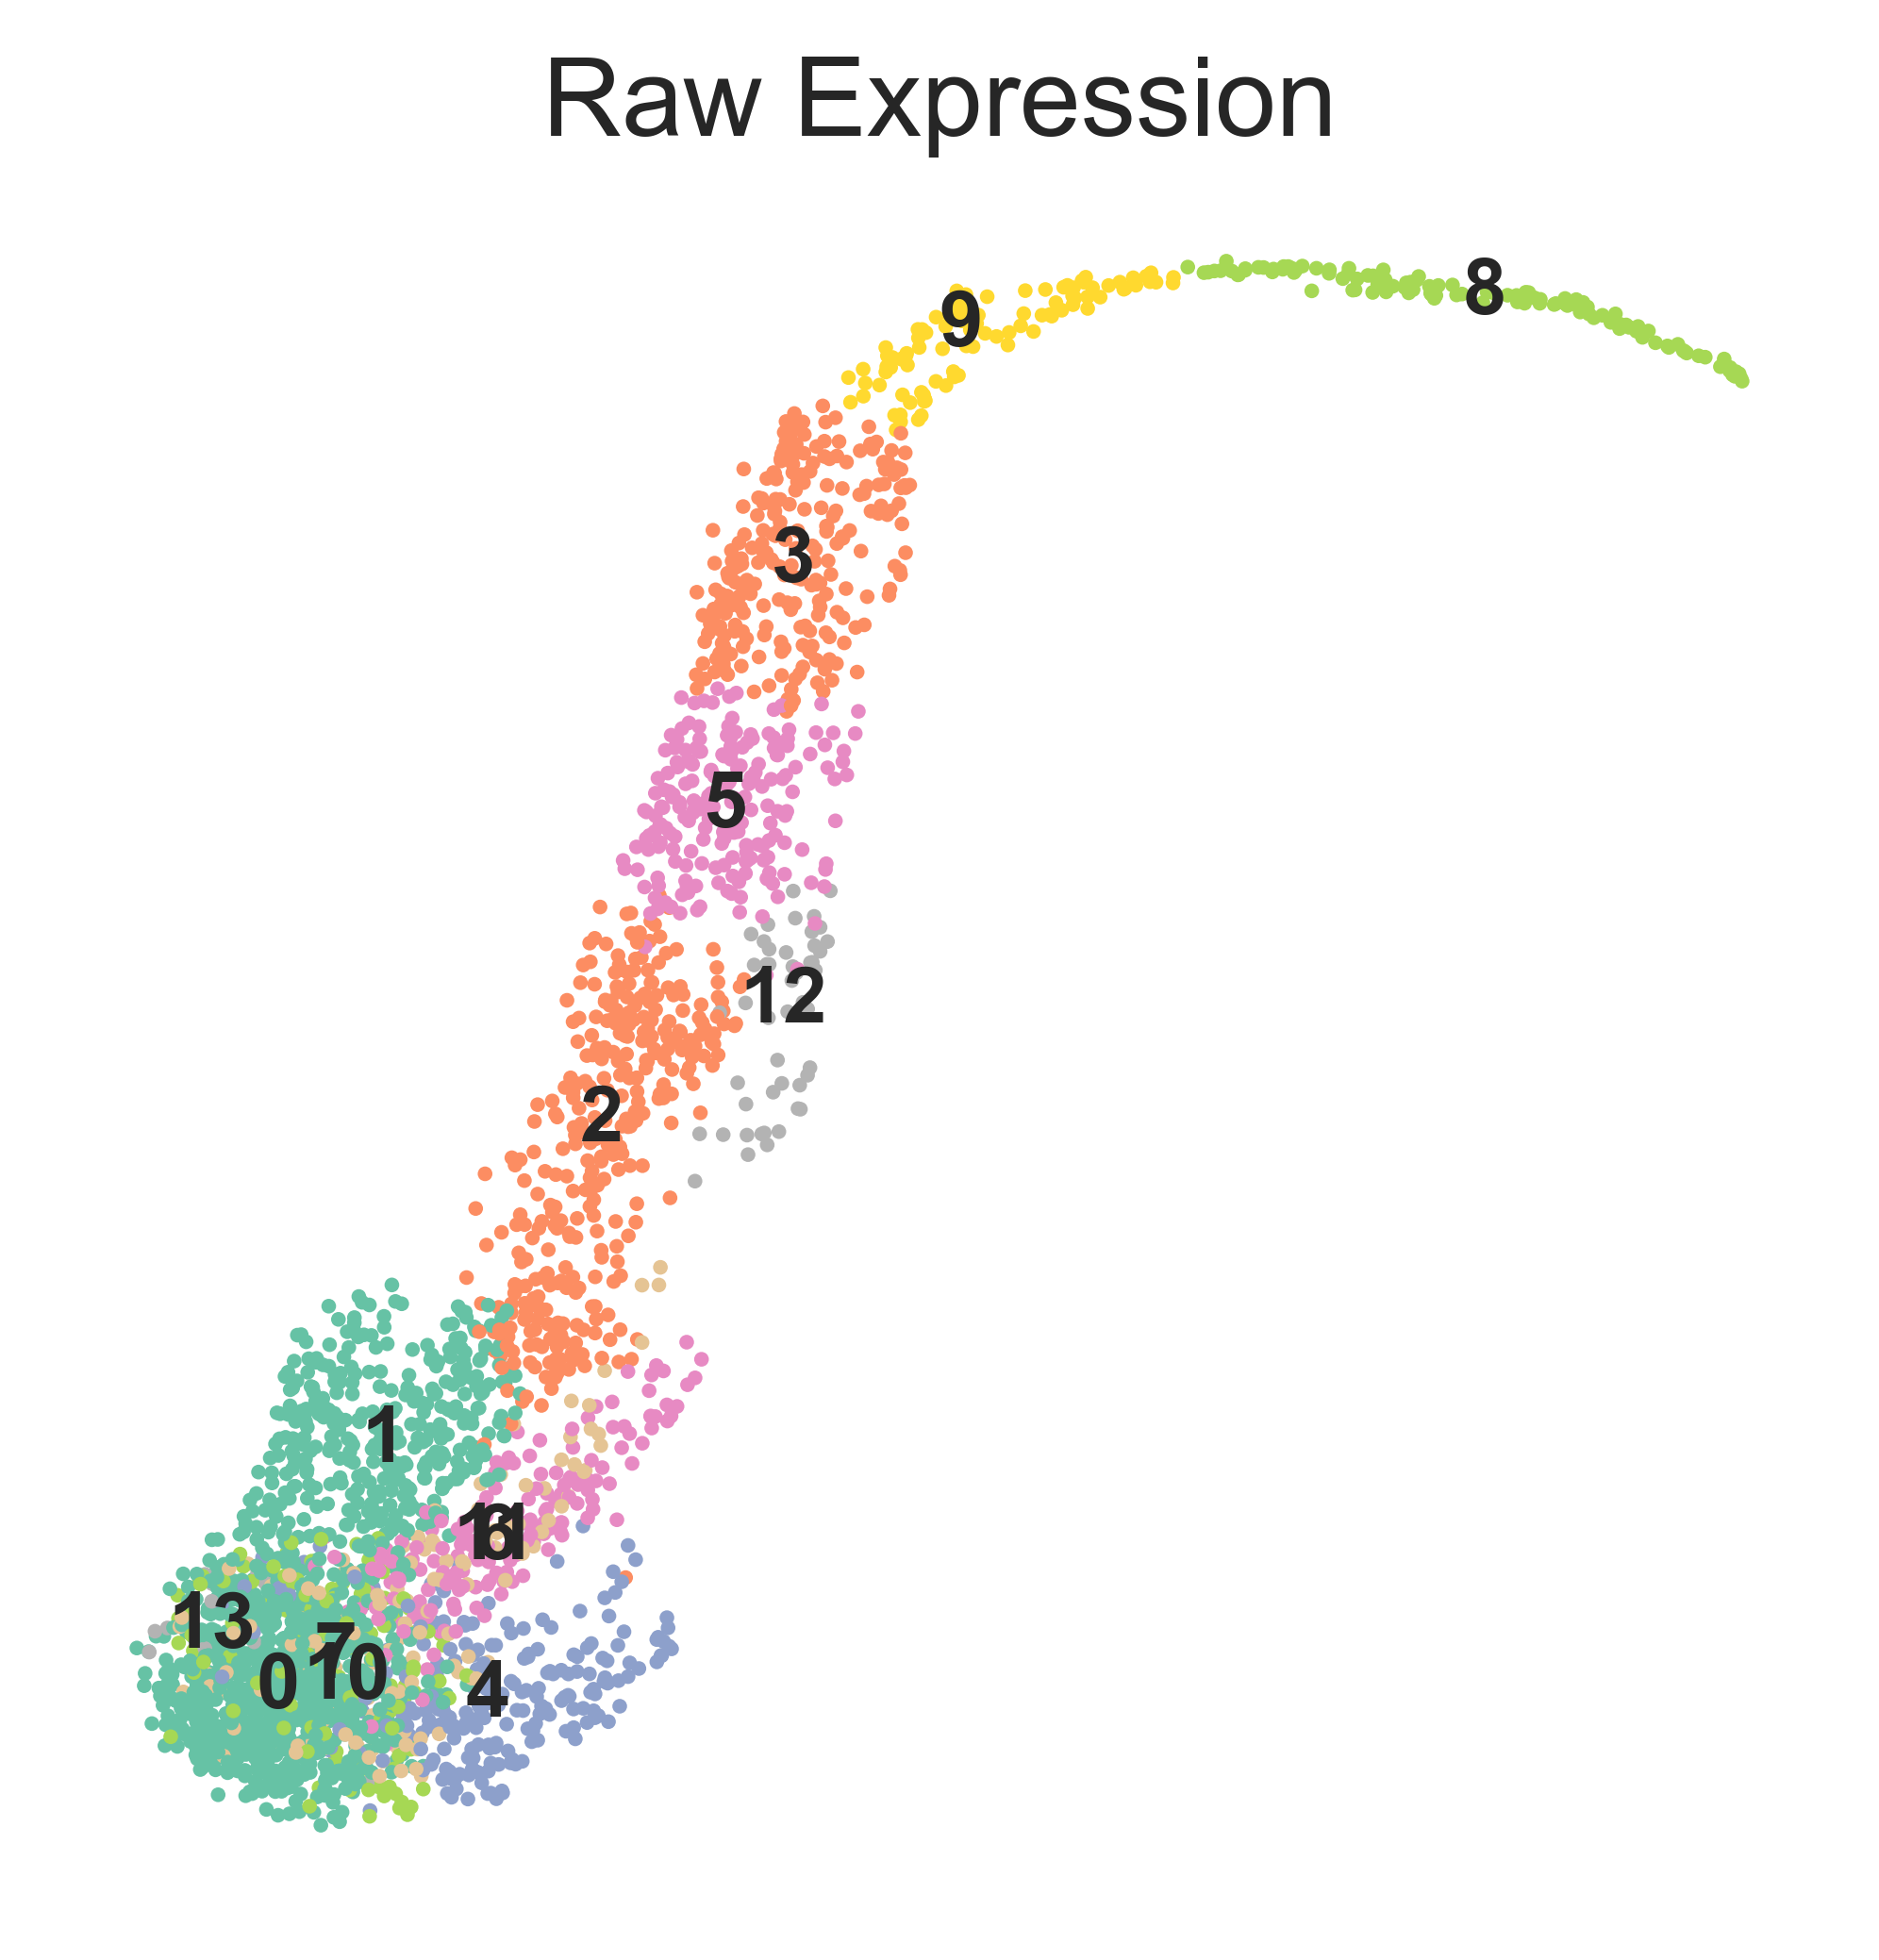

In [ ]:
adata_raw = sc.AnnData(X=node_features.values)
adata_raw.obs_names = node_features.index
adata_raw.var_names = [f"gene_feature_{i}" for i in range(node_features.shape[1])]

sc.pp.neighbors(adata_raw, n_neighbors=10, use_rep="X")
sc.tl.leiden(adata_raw, resolution=1.24)
sc.tl.umap(adata_raw)

sc.pl.umap(adata_raw, color="leiden", legend_loc="on data", legend_fontsize=10,
           title="Raw Expression", frameon=False, 
           palette="Set2", size=14)


## Simple MLP predictor model for learning annotation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, random_split
import copy
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import gseapy as gp
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                                                                                                    #KEGG_2019_Mouse KEGG_2021_Human
def create_annotation(node_features, embedded_genes, annotation_set,threshold=30):

    #KEGG_custom = gp.get_library("GO_Biological_Process_2023")
    node_features.index = node_features.index.str.upper()
    all_genes = node_features.index
    filtered = {pathway: [gene for gene in genes if gene in all_genes]
                  for pathway, genes in annotation_set.items()}
    array = [ (gene, key) for key in filtered for gene in filtered[key] ]
    kegg_df = pd.DataFrame(array)
    annot = pd.DataFrame(0, index=all_genes, columns=filtered.keys())

    for key, values in filtered.items():
        for value in values:
            annot.loc[value, key] = 1

    annot_threshold = annot.sum()>threshold
    activate_genes = annot[annot_threshold[annot_threshold].index].sum(axis=1) > 0
    annot = annot[annot_threshold[annot_threshold].index]
    annot = annot.loc[activate_genes]
    row_embedding_df = pd.DataFrame(embedded_genes, index=node_features.index)
    row_embedding_df = row_embedding_df.loc[activate_genes]
    node_features = node_features.loc[activate_genes]
    return annot, row_embedding_df, node_features

BATCH_SIZE = 64
SEED = 2025

class MLPredictor(torch.nn.Module):
    def __init__(self, featue_dim,inter_dim,label_num, drop_p = 0.2):
        super(MLPredictor, self).__init__()
        self.featue_dim = featue_dim
        self.inter_dim = inter_dim
        self.embedding = nn.Sequential(nn.Linear(featue_dim, inter_dim),
                                nn.BatchNorm1d(inter_dim),
                                nn.Dropout(drop_p),
                                nn.ReLU(),
                                nn.Linear(inter_dim, inter_dim),
                                nn.BatchNorm1d(inter_dim),
                                nn.Dropout(drop_p),
                                nn.ReLU())
        self.predictor =  nn.Linear(inter_dim, label_num)

    def forward(self, z):
        embd =  self.embedding(z)
        return self.predictor(embd)


class annotDataset(Dataset):
    def __init__(self, x, labels=None):
        self.x = torch.tensor(x.T).to(torch.float32)
        if not labels is None:
          self.outcome = torch.tensor(labels).type(torch.LongTensor)
        else:
          self.outcome = None


    def __len__(self):
        return self.x.shape[1]

    def __getitem__(self, idx):
        if self.outcome is None:
            return self.x[:,idx] , idx

        return self.x[:,idx] ,self.outcome[idx], idx


def test(model,loader,):
  model.eval()
  y_pred_list = []
  y_list = []

  for batch in loader:
    x = batch[0].to(device)
    y = batch[1].to(device)
    y_pred = model(x)

    y_pred_list.append(y_pred.detach().cpu().numpy().reshape(-1))
    y_list.append(y.detach().cpu().numpy().reshape(-1))

  probabilities = torch.sigmoid(torch.tensor(np.concatenate(y_pred_list)))
  return roc_auc_score(np.concatenate(y_list), np.concatenate(y_pred_list)),average_precision_score(np.concatenate(y_list), np.concatenate(y_pred_list))

def predict_function(X, Y, kf):

  results_auc = []
  results_aupr = []
  models = []

  for train_index, test_index in kf.split(X):
      X_train, X_test = X[train_index],X[test_index]
      y_train, y_test = Y[train_index], Y[test_index]

      dataset_train = annotDataset(X_train, y_train)
      dataset_test = annotDataset(X_test, y_test)
      train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
      test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)
      model = MLPredictor(featue_dim=X.shape[1],inter_dim=500,label_num=Y.shape[1]).to(device)

      num_negatives = (1-y_train).sum(axis=0)
      num_positives = y_train.sum(axis=0)
      pos_weight = num_negatives / num_positives
      criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.cpu())

      best_auc = 0
      best_aupr = 0
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
      model.to(device)

      for epoch in range(100):
        model.train()
        for batch in train_loader:
          x = batch[0].to(device)
          y_beach = batch[1].to(device)
          y_pred = model(x)
          loss = criterion(y_pred.cpu(), y_beach.float().cpu())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        auc,aupr = test(model,test_loader)
        if aupr > best_aupr:
          best_auc = auc
          best_aupr = aupr
      results_auc.append(best_auc)
      results_aupr.append(best_aupr)
  return results_auc, results_aupr

## apply the model on the gene embedding, the original counts and a permutations of the counts matrix as random results.

In [147]:
embedded_genes, embedded_cells, node_features , out_features = STCOGAT.load_embeddings("Lymph_Node_gene")
embedded_genes.shape,embedded_cells.shape,node_features.shape,out_features.shape

((2975, 28), (4035, 42), (2975, 4035), (4035, 2975))

In [120]:
node_features = raw.to_df()[node_features.index].T

In [ ]:
annot, row_embedding_df, node_features = create_annotation(node_features, embedded_genes,annotation_set=gp.get_library("GO_Biological_Process_2023"),threshold=30)

In [149]:
Y = torch.tensor(annot.values).to(device)
kf = KFold(n_splits=10, shuffle=True, random_state=28)
results = [predict_function(torch.tensor(df.values).float().to(device),Y, kf) for df in [row_embedding_df,node_features,node_features.sample(frac=1,replace=False)]]

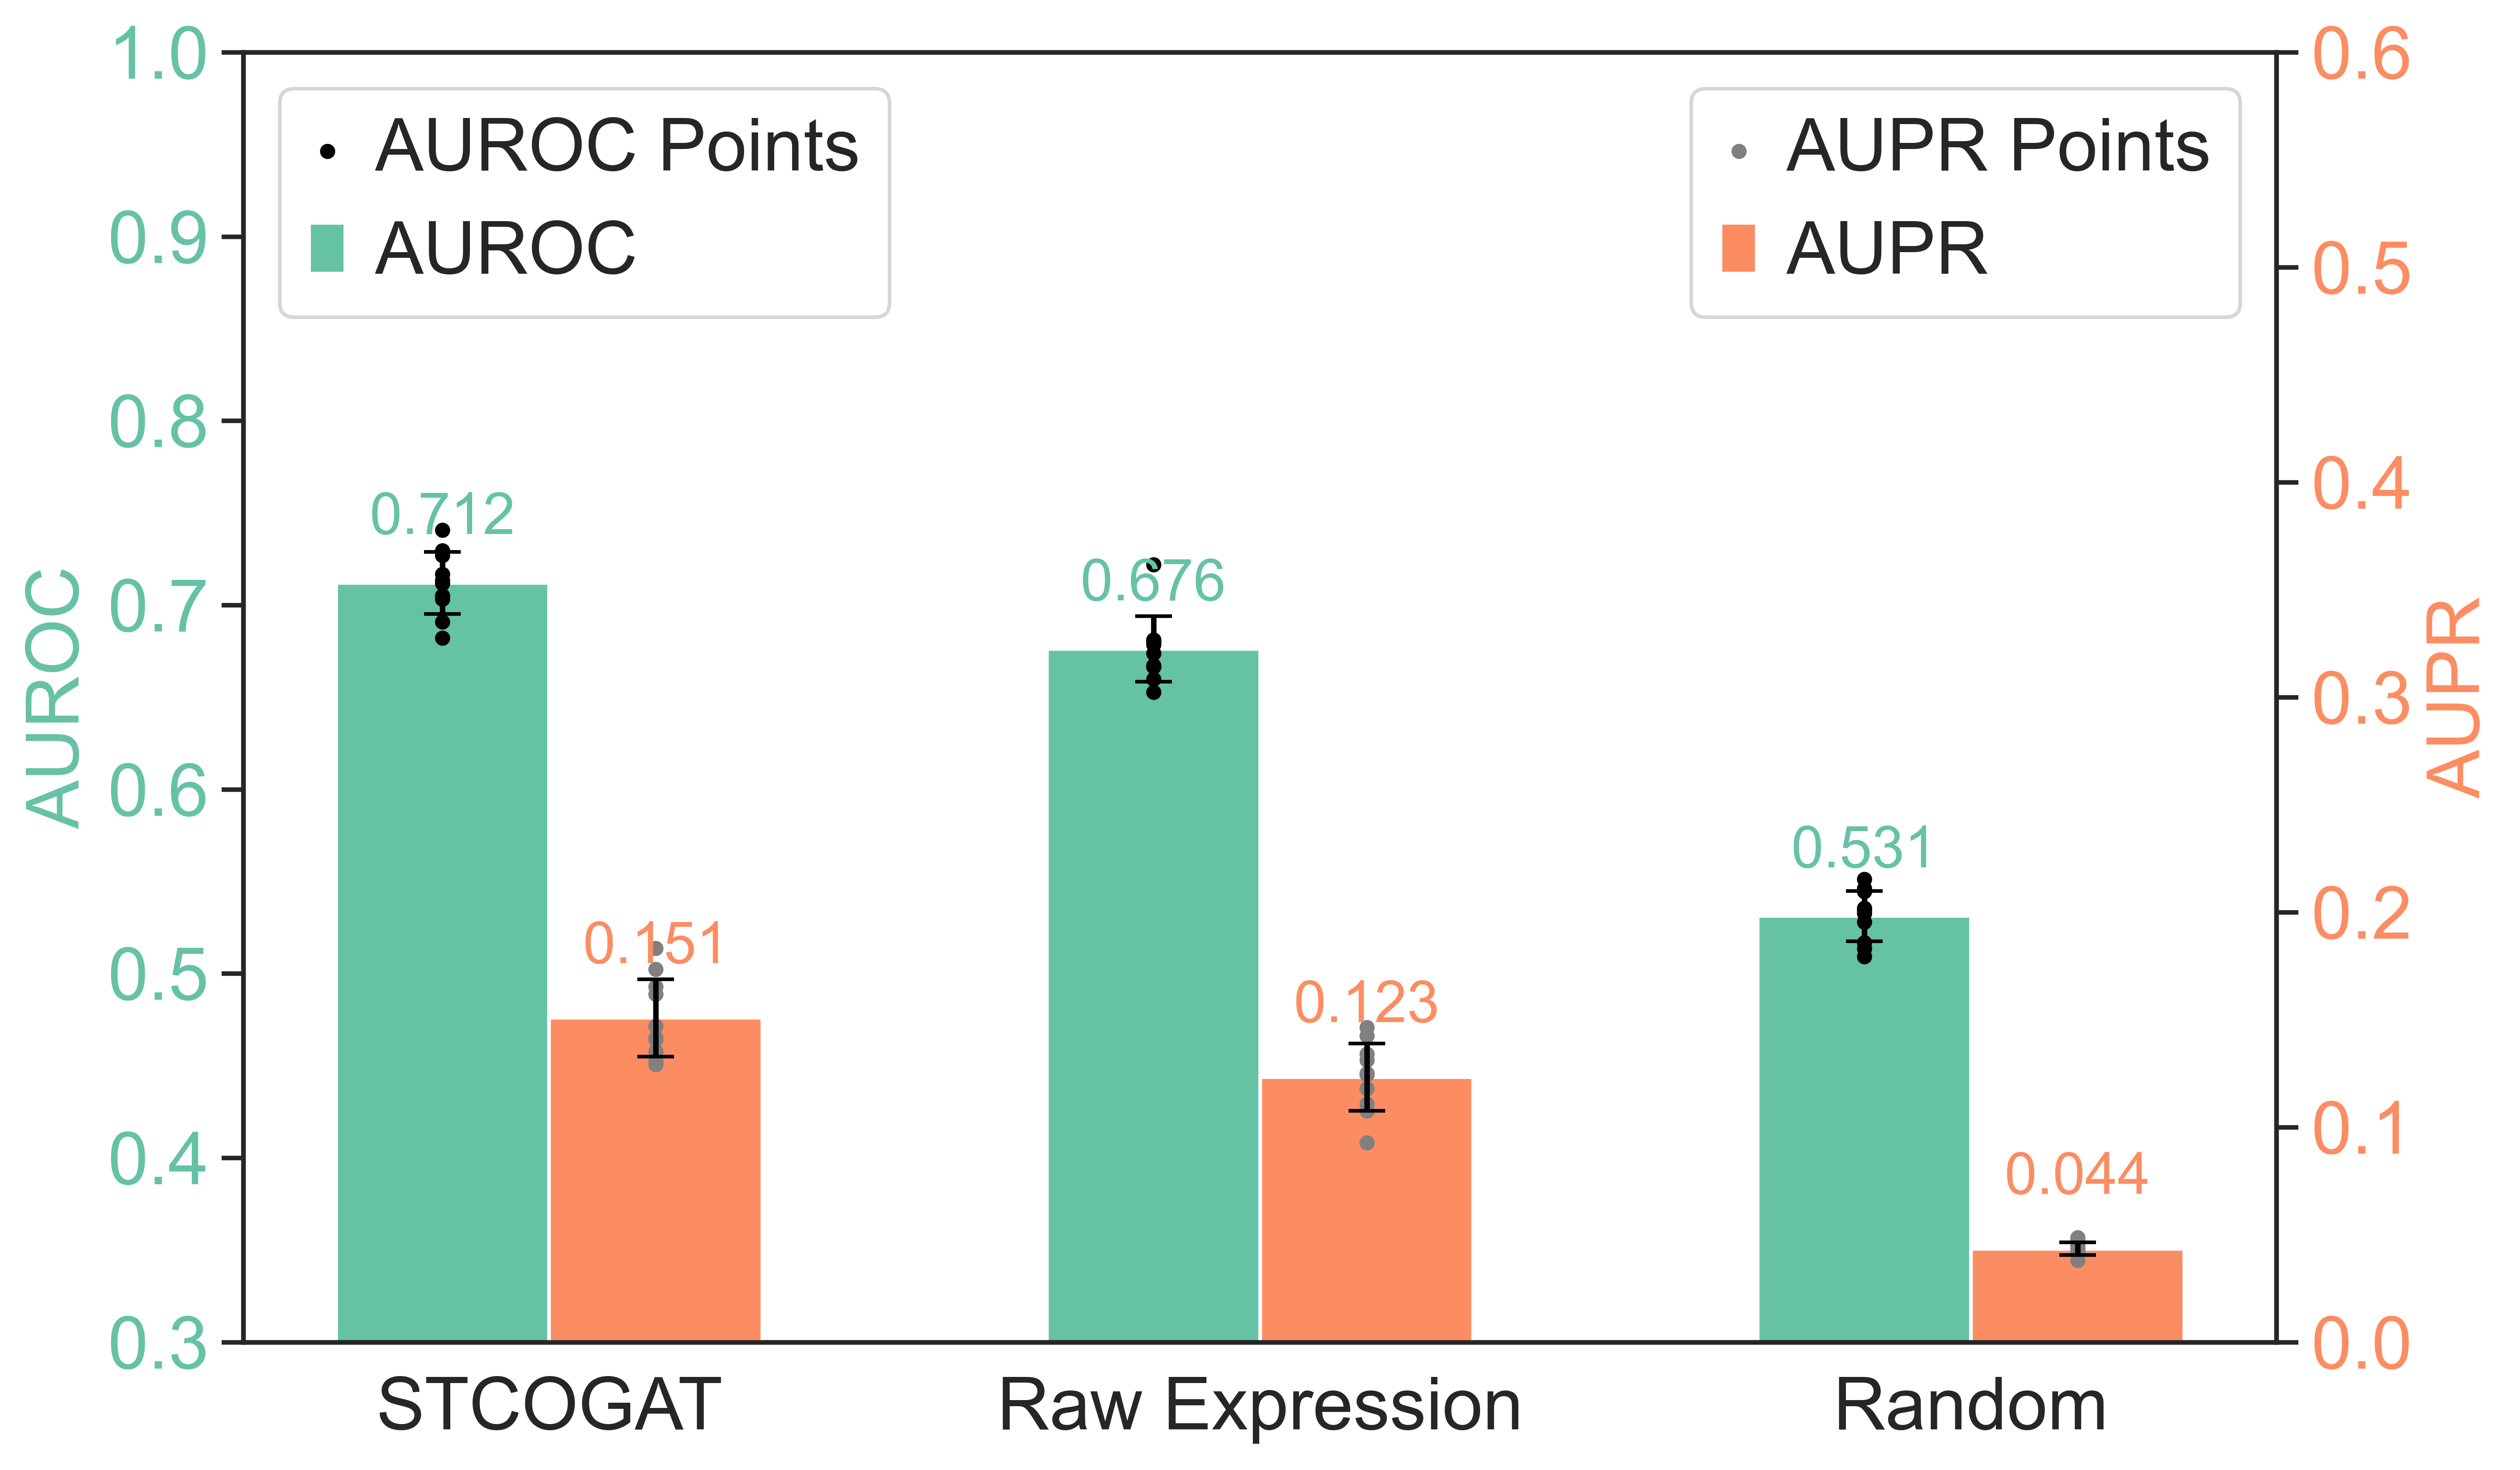

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="white", palette="Set2")
plt.rcParams.update({
    "font.size": 20,        
    "axes.titlesize": 20,  
    "axes.labelsize": 20, 
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 20
})

methods = ['STCOGAT', 'Raw Expression', 'Random']

aurocs = [np.mean(method[0]) for method in results]
auprcs = [np.mean(method[1]) for method in results]
aurocs_err = [np.std(method[0]) for method in results]
auprcs_err = [np.std(method[1]) for method in results]

x = np.arange(len(methods))
bar_width = 0.3

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(x - bar_width / 2, aurocs, yerr=aurocs_err,
        width=bar_width, label='AUROC',
        color=sns.color_palette("Set2")[0], capsize=5)
ax1.set_xlabel('')
ax1.set_ylabel('AUROC', color=sns.color_palette("Set2")[0])
ax1.tick_params(axis='y', labelcolor=sns.color_palette("Set2")[0])
ax1.set_xticks(x)
ax1.set_xticklabels(methods)
ax1.set_ylim([0.3, 1])

ax2 = ax1.twinx()
ax2.bar(x + bar_width / 2, auprcs, yerr=auprcs_err,
        width=bar_width, label='AUPR',
        color=sns.color_palette("Set2")[1], capsize=5)
ax2.set_ylabel('AUPR', color=sns.color_palette("Set2")[1])
ax2.tick_params(axis='y', labelcolor=sns.color_palette("Set2")[1])
ax2.set_ylim([0, 0.6])

for i, (aurocs_data, auprcs_data) in enumerate(results):
    ax1.scatter([i - bar_width / 2] * len(aurocs_data), aurocs_data,
                color="black", s=10, label='AUROC Points' if i == 0 else "")
    ax2.scatter([i + bar_width / 2] * len(auprcs_data), auprcs_data,
                color="gray", s=10, label='AUPR Points' if i == 0 else "")

for i, v in enumerate(aurocs):
    ax1.text(i - bar_width / 2, v + 0.02, f"{v:.3f}",
             ha='center', va='bottom', fontsize=16, color=sns.color_palette("Set2")[0])

for i, v in enumerate(auprcs):
    ax2.text(i + bar_width / 2, v + 0.02, f"{v:.3f}",
             ha='center', va='bottom', fontsize=16, color=sns.color_palette("Set2")[1])

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()


## test the reconstructed gene expression using the Hallmark 2020 gene sets:

In [151]:
embedded_genes, embedded_cells, node_features , out_features =  STCOGAT.load_embeddings("Lymph_Node_gene")
annot, out_features_df, node_features = create_annotation(node_features, out_features.T, annotation_set=gp.get_library("MSigDB_Hallmark_2020"), threshold=20)

In [153]:
Y = torch.tensor(annot.values).to(device)
kf = KFold(n_splits=10, shuffle=True, random_state=28)
results = [predict_function(torch.tensor(df.values).float().to(device),Y, kf) for df in [out_features_df,node_features,node_features.sample(frac=1,replace=False)]]

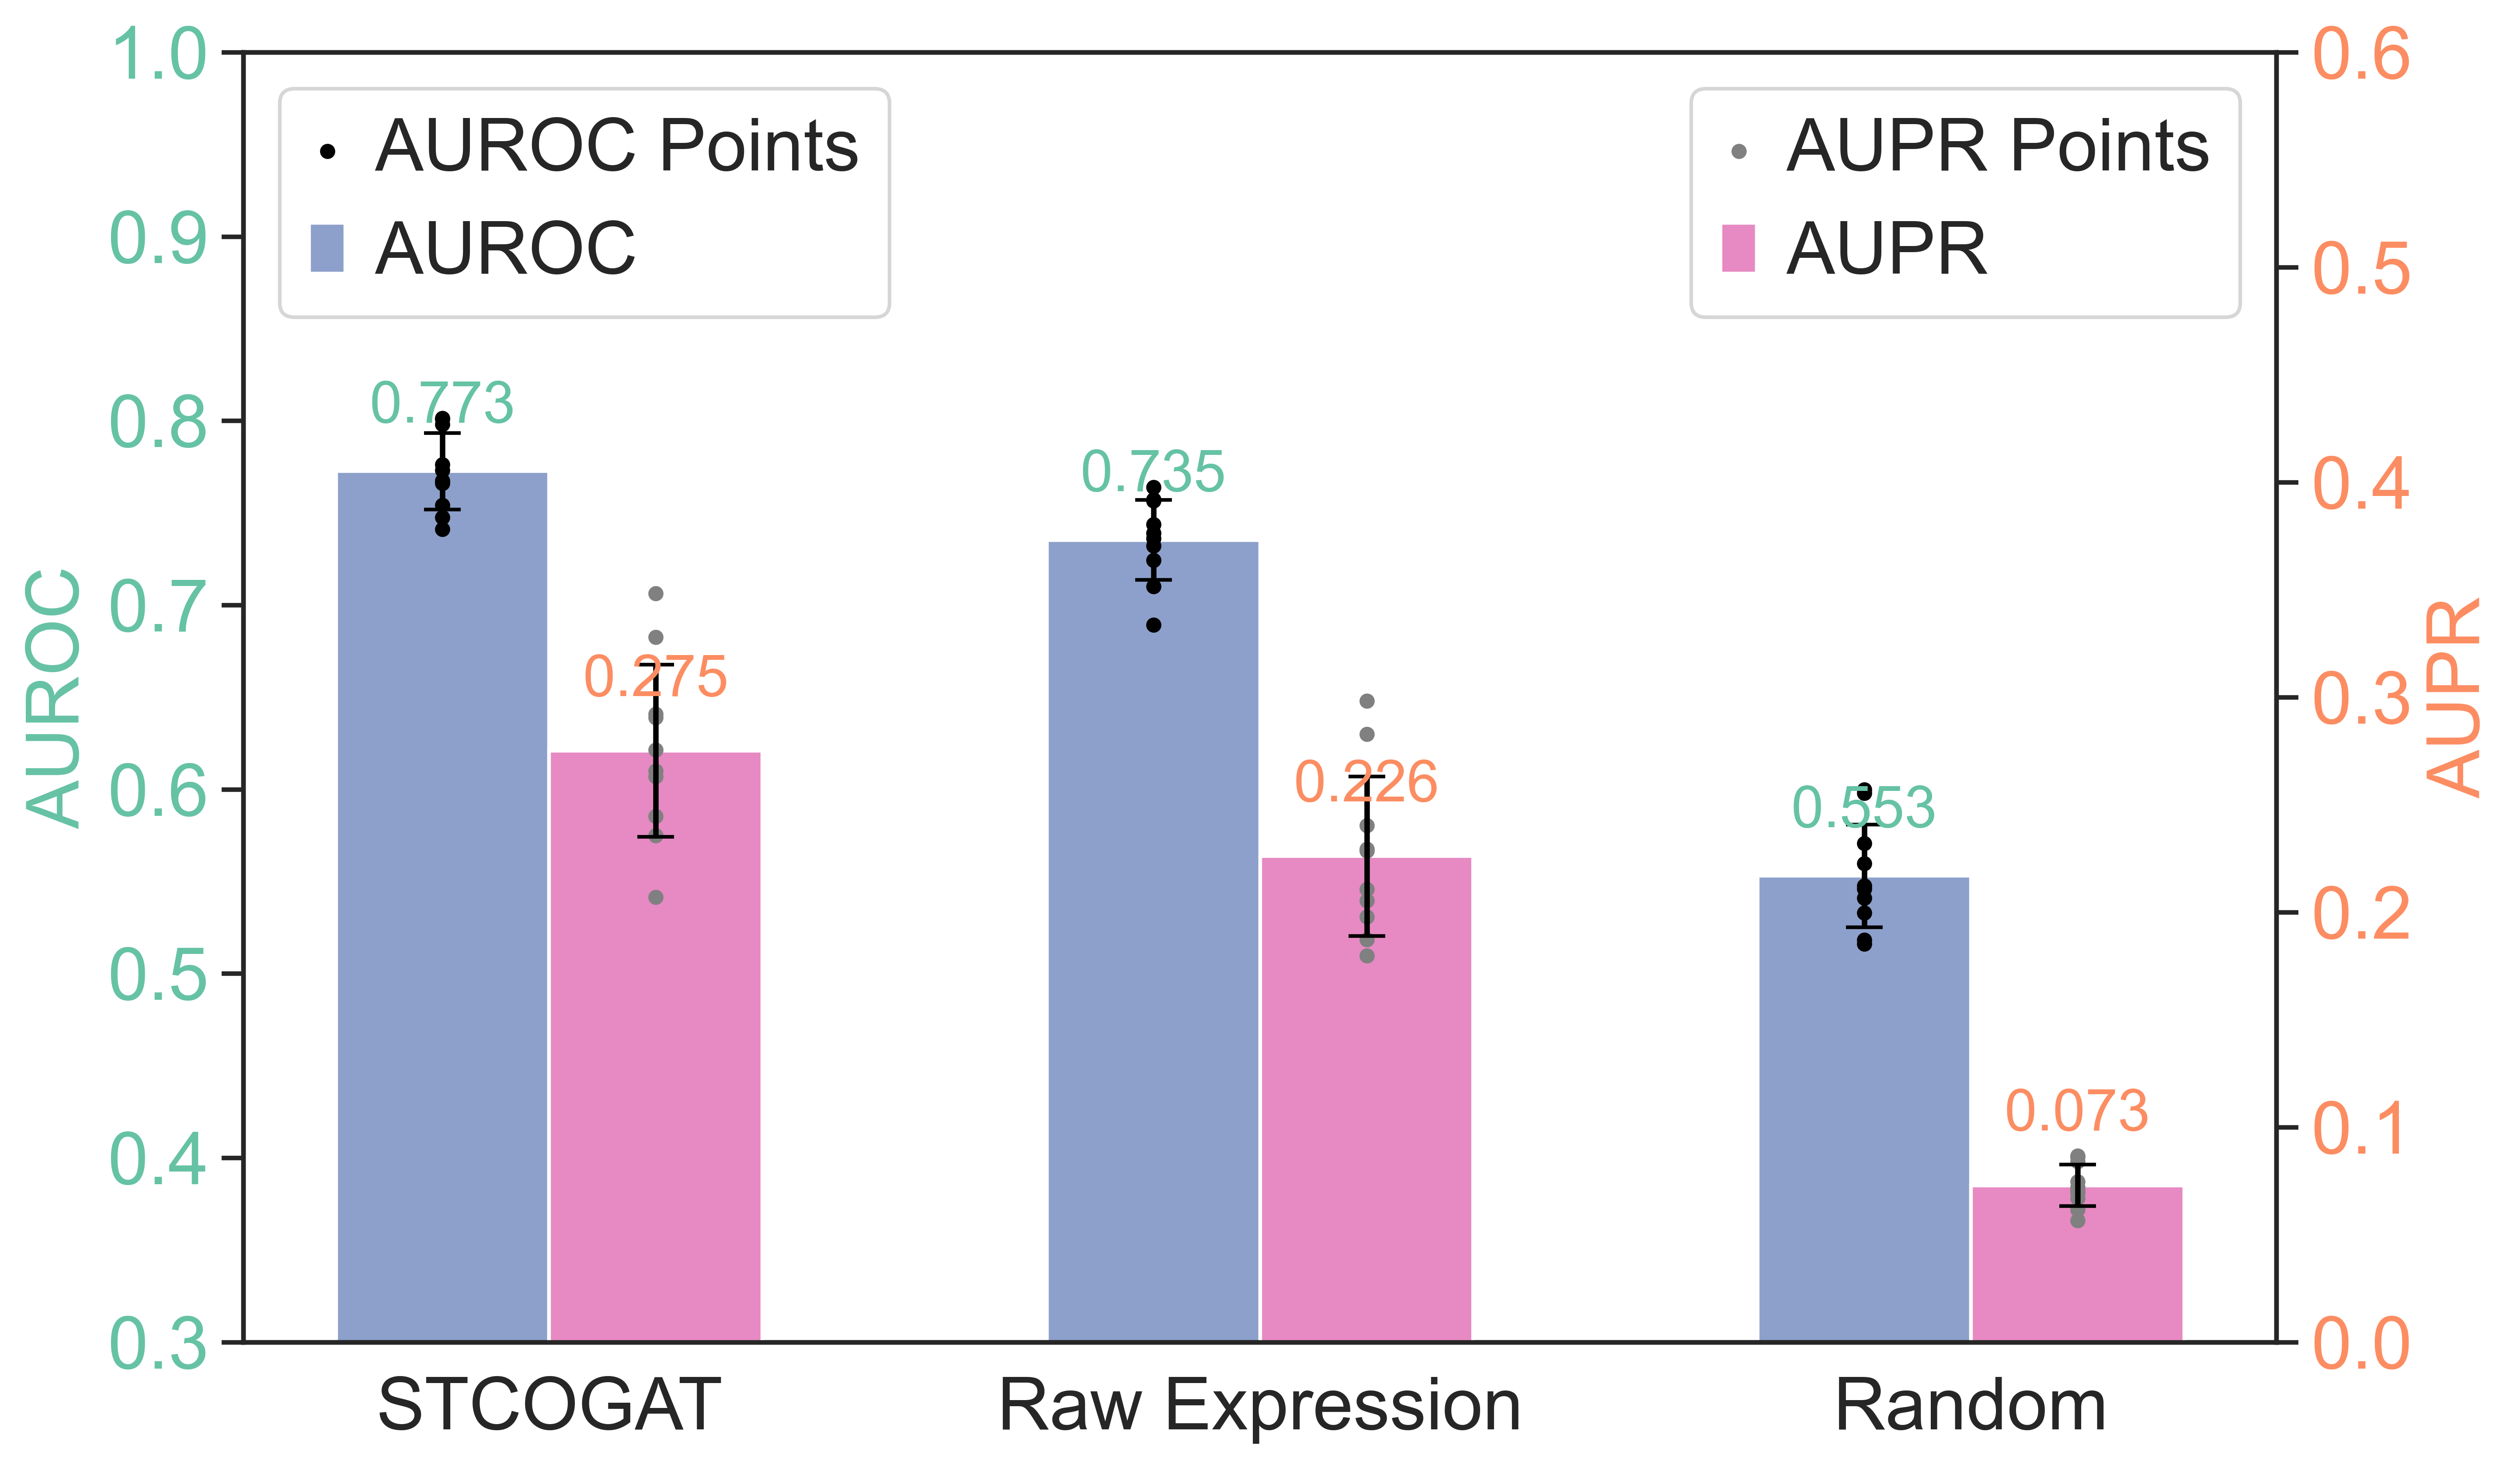

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="white", palette="Set2")
plt.rcParams.update({
    "font.size": 20,        
    "axes.titlesize": 20,  
    "axes.labelsize": 20,   
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 20
})

methods = ['STCOGAT', 'Raw Expression', 'Random']

aurocs = [np.mean(method[0]) for method in results]
auprcs = [np.mean(method[1]) for method in results]
aurocs_err = [np.std(method[0]) for method in results]
auprcs_err = [np.std(method[1]) for method in results]

x = np.arange(len(methods))
bar_width = 0.3

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(x - bar_width / 2, aurocs, yerr=aurocs_err,
        width=bar_width, label='AUROC',
        color=sns.color_palette("Set2")[2], capsize=5)
ax1.set_xlabel('')
ax1.set_ylabel('AUROC', color=sns.color_palette("Set2")[2])
ax1.tick_params(axis='y', labelcolor=sns.color_palette("Set2")[2])
ax1.set_xticks(x)
ax1.set_xticklabels(methods)
ax1.set_ylim([0.3, 1])

ax2 = ax1.twinx()
ax2.bar(x + bar_width / 2, auprcs, yerr=auprcs_err,
        width=bar_width, label='AUPR',
        color=sns.color_palette("Set2")[3], capsize=5)
ax2.set_ylabel('AUPR', color=sns.color_palette("Set2")[3])
ax2.tick_params(axis='y', labelcolor=sns.color_palette("Set2")[3])
ax2.set_ylim([0, 0.6])

for i, (aurocs_data, auprcs_data) in enumerate(results):
    ax1.scatter([i - bar_width / 2] * len(aurocs_data), aurocs_data,
                color="black", s=10, label='AUROC Points' if i == 0 else "")
    ax2.scatter([i + bar_width / 2] * len(auprcs_data), auprcs_data,
                color="gray", s=10, label='AUPR Points' if i == 0 else "")

for i, v in enumerate(aurocs):
    ax1.text(i - bar_width / 2, v + 0.02, f"{v:.3f}",
             ha='center', va='bottom', fontsize=16, color=sns.color_palette("Set2")[2])

for i, v in enumerate(auprcs):
    ax2.text(i + bar_width / 2, v + 0.02, f"{v:.3f}",
             ha='center', va='bottom', fontsize=16, color=sns.color_palette("Set2")[3])

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()


## run the same process on GO Molecular Function Gene sets:

In [15]:
embedded_genes, embedded_cells, node_features , out_features =  STCOGAT.load_embeddings("Lymph_Node_gene")
annot, row_embedding_df, node_features = create_annotation(node_features, embedded_genes, annotation_set=gp.get_library("GO_Molecular_Function_2023"), threshold=20)

In [17]:
Y = torch.tensor(annot.values).to(device)
kf = KFold(n_splits=10, shuffle=True, random_state=28)
results = [predict_function(torch.tensor(df.values).float().to(device),Y, kf) for df in [row_embedding_df,node_features,node_features.sample(frac=1,replace=False)]]

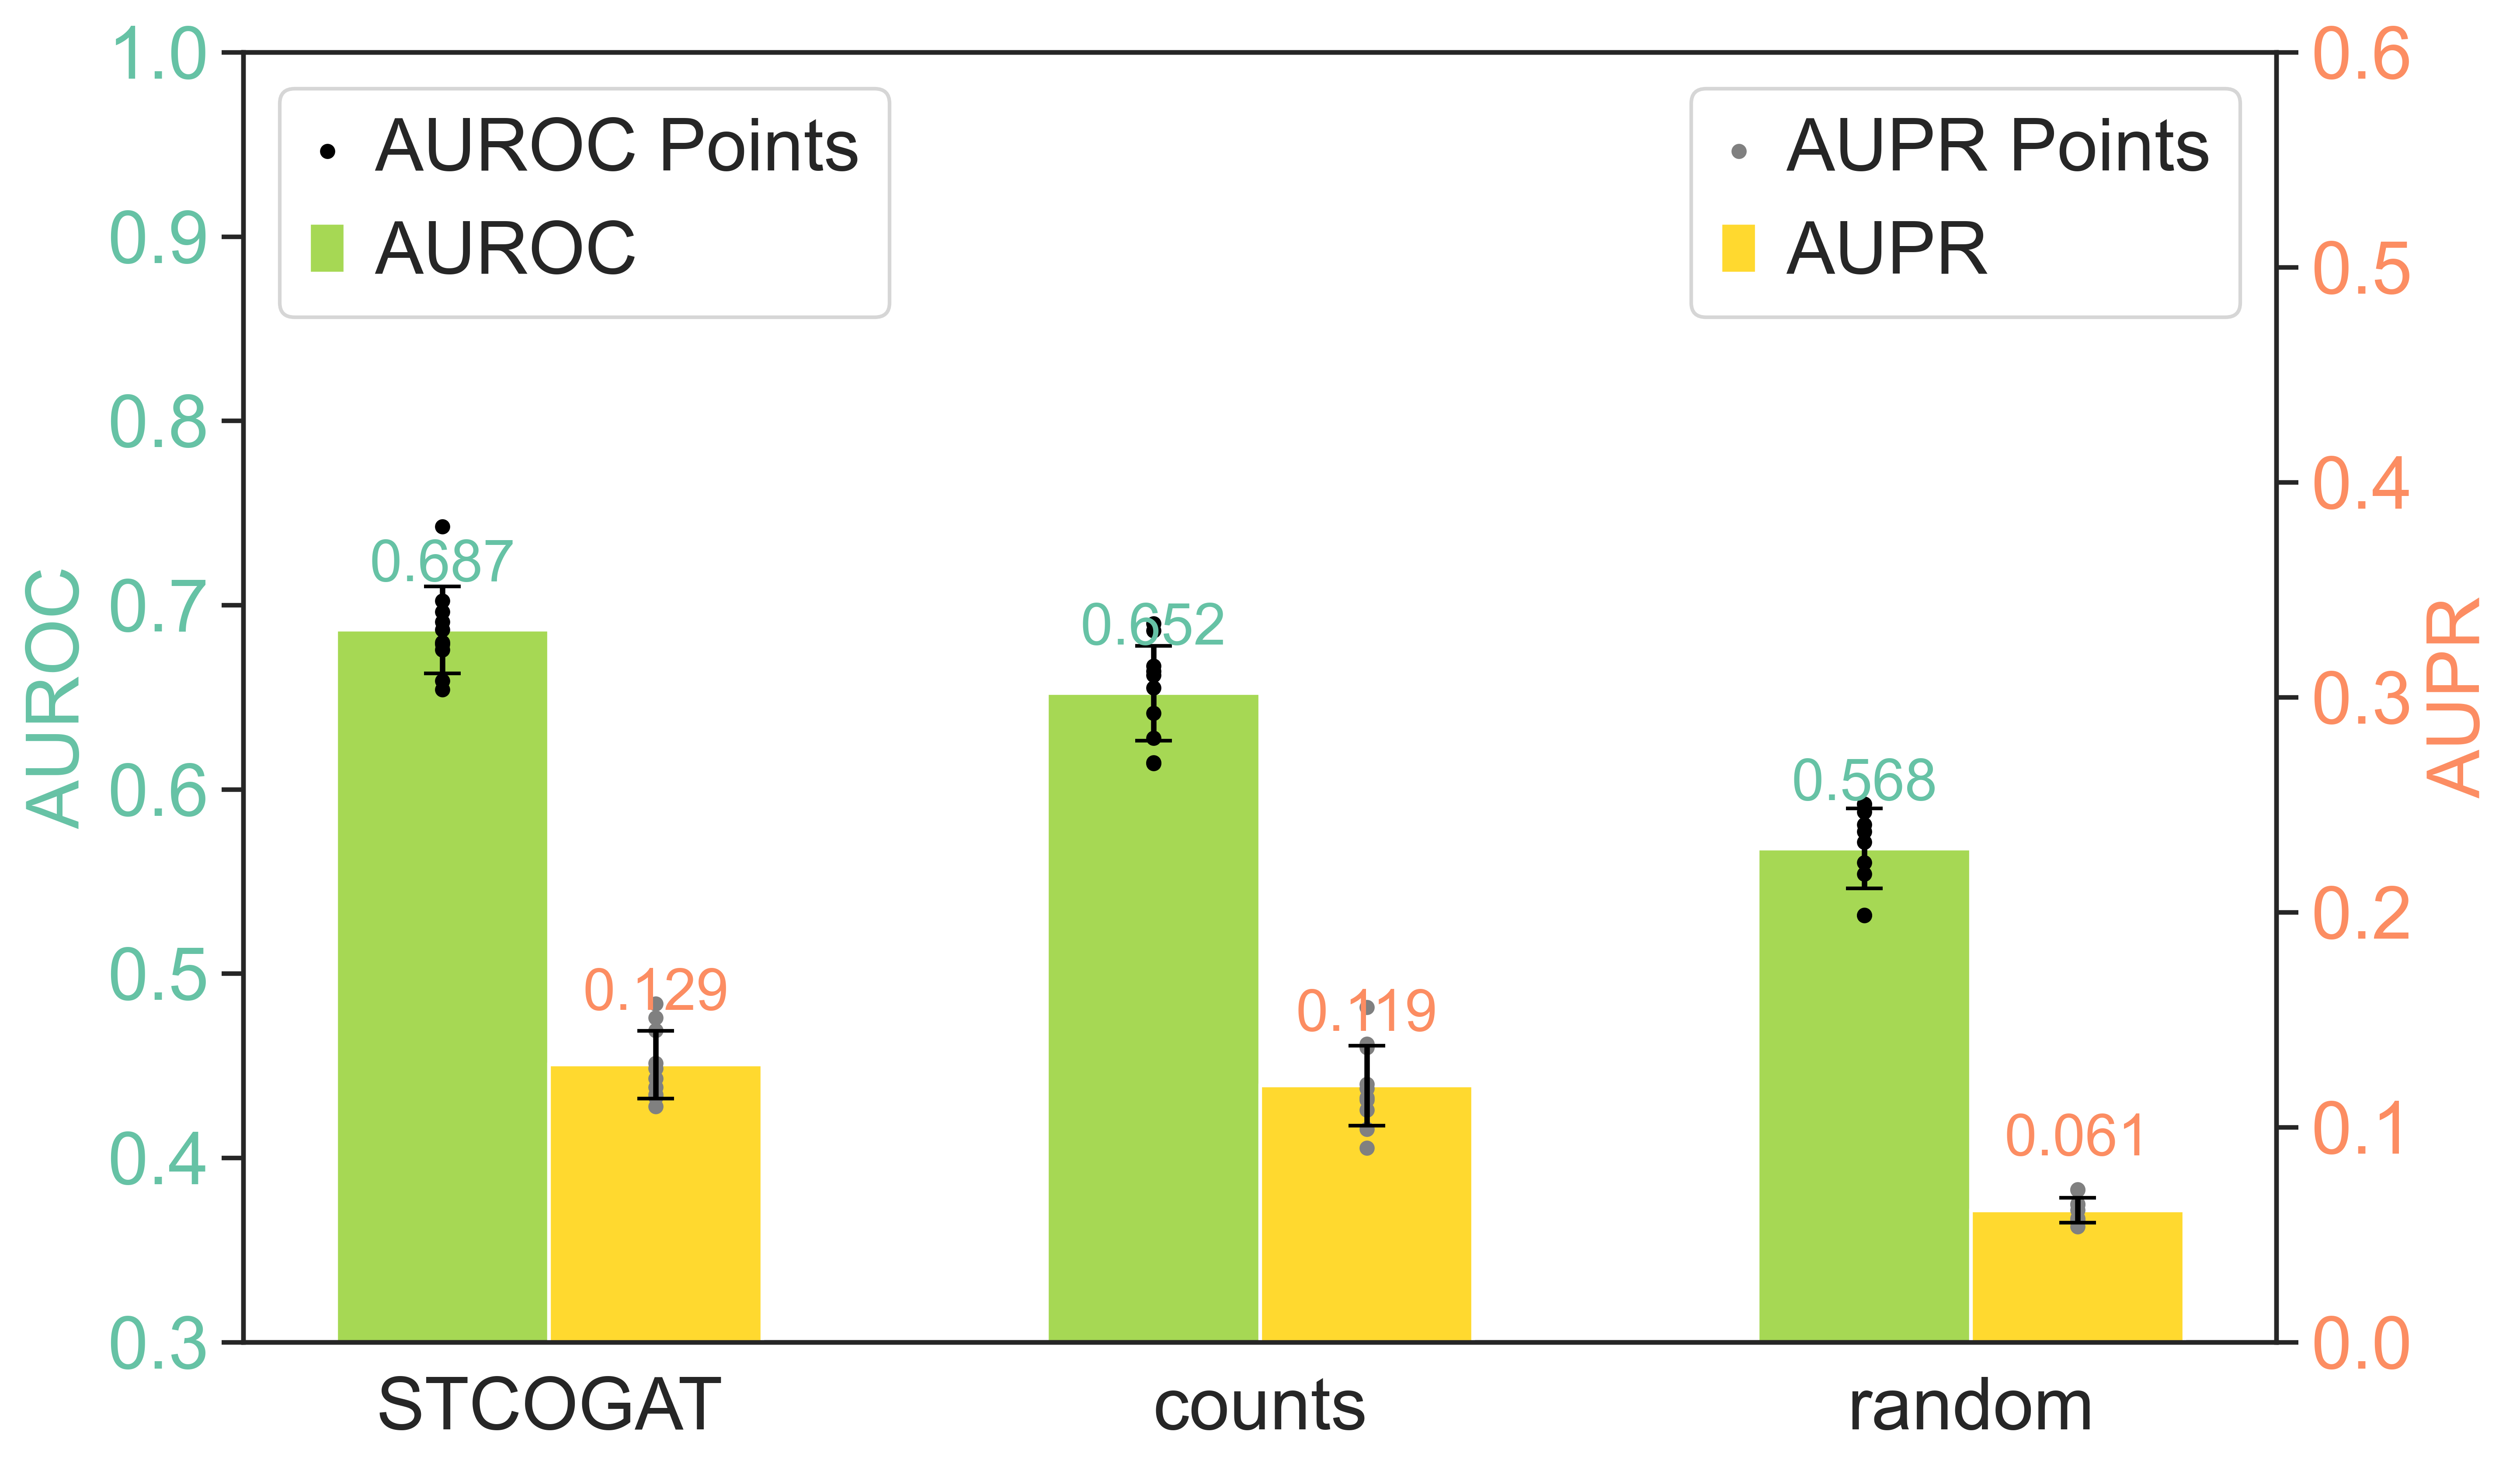

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="white", palette="Set2")
plt.rcParams.update({
    "font.size": 20,        
    "axes.titlesize": 20,  
    "axes.labelsize": 20,  
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 20
})

methods = ['STCOGAT', 'counts', 'random']

aurocs = [np.mean(method[0]) for method in results]
auprcs = [np.mean(method[1]) for method in results]
aurocs_err = [np.std(method[0]) for method in results]
auprcs_err = [np.std(method[1]) for method in results]

x = np.arange(len(methods))
bar_width = 0.3

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(x - bar_width / 2, aurocs, yerr=aurocs_err,
        width=bar_width, label='AUROC',
        color=sns.color_palette("Set2")[4], capsize=5)
ax1.set_xlabel('')
ax1.set_ylabel('AUROC', color=sns.color_palette("Set2")[4])
ax1.tick_params(axis='y', labelcolor=sns.color_palette("Set2")[4])
ax1.set_xticks(x)
ax1.set_xticklabels(methods)
ax1.set_ylim([0.3, 1])

ax2 = ax1.twinx()
ax2.bar(x + bar_width / 2, auprcs, yerr=auprcs_err,
        width=bar_width, label='AUPR',
        color=sns.color_palette("Set2")[5], capsize=5)
ax2.set_ylabel('AUPR', color=sns.color_palette("Set2")[5])
ax2.tick_params(axis='y', labelcolor=sns.color_palette("Set2")[5])
ax2.set_ylim([0, 0.6])

for i, (aurocs_data, auprcs_data) in enumerate(results):
    ax1.scatter([i - bar_width / 2] * len(aurocs_data), aurocs_data,
                color="black", s=10, label='AUROC Points' if i == 0 else "")
    ax2.scatter([i + bar_width / 2] * len(auprcs_data), auprcs_data,
                color="gray", s=10, label='AUPR Points' if i == 0 else "")

for i, v in enumerate(aurocs):
    ax1.text(i - bar_width / 2, v + 0.02, f"{v:.3f}",
             ha='center', va='bottom', fontsize=16, color=sns.color_palette("Set2")[4])

for i, v in enumerate(auprcs):
    ax2.text(i + bar_width / 2, v + 0.02, f"{v:.3f}",
             ha='center', va='bottom', fontsize=16, color=sns.color_palette("Set2")[5])

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()
